# Clustering Model for Shopping Trends

This notebook segments customers based on their purchase patterns, demographics, and engineered features using clustering algorithms.

## Clustering Process Outline

- Load and preprocess the engineered dataset
- Select and evaluate clustering algorithms
- Determine optimal number of clusters
- Train and interpret the clustering model
- Visualize and save results

## Step 1: Import Required Libraries

We use pandas for data manipulation, scikit-learn for clustering and preprocessing, matplotlib/seaborn for visualization, and plotly for interactive plots.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import plotly.express as px

## Step 2: Load the Engineered Dataset

Read the enhanced dataset and display the first few rows.

In [2]:
df = pd.read_csv('shopping_trends_engineered.csv')
df.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,...,Previous Purchases,Preferred Payment Method,Frequency of Purchases,CLV,Purchase_Frequency_Score,Age_Group,Discount_Sensitivity,Dominant_Category,Winter_Spring_Buyer,Review_Rating_Category
0,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,...,14,Venmo,Fortnightly,742,6,Senior,1,Clothing,1,Medium
1,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,...,2,Cash,Fortnightly,128,6,Young,1,Clothing,1,Medium
2,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,...,23,Credit Card,Weekly,1679,7,Middle,1,Clothing,1,Medium
3,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,...,49,PayPal,Weekly,4410,7,Young,1,Footwear,1,Medium
4,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,...,31,PayPal,Annually,1519,1,Middle,1,Clothing,1,Low


## Step 3: Identify Feature Types

Separate columns into numerical and categorical for preprocessing.

In [3]:
numerical_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 
                  'CLV', 'Purchase_Frequency_Score', 'Discount_Sensitivity', 'Winter_Spring_Buyer']
categorical_cols = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 
                    'Season', 'Subscription Status', 'Payment Method', 'Shipping Type', 
                    'Discount Applied', 'Promo Code Used', 'Preferred Payment Method', 
                    'Frequency of Purchases', 'Age_Group', 'Dominant_Category', 'Review_Rating_Category']

## Step 4: Preprocessing Pipeline

Scale numerical features and one-hot encode categorical features using scikit-learn's `ColumnTransformer`.

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

## Step 5: Apply Preprocessing

Fit and transform the data using the pipeline.

In [5]:
X = preprocessor.fit_transform(df)

## Step 6: Retrieve Feature Names

Get the new feature names after one-hot encoding for reference.

In [6]:
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)
X = pd.DataFrame(X, columns=feature_names)

## Step 7: Determine Optimal Number of Clusters

Use the elbow method and silhouette scores to select the best number of clusters for K-Means.

In [7]:
wcss = []
silhouette_scores = []
max_clusters = 10
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

### Elbow Curve

Plot the within-cluster sum of squares (WCSS) to find the 'elbow' point.

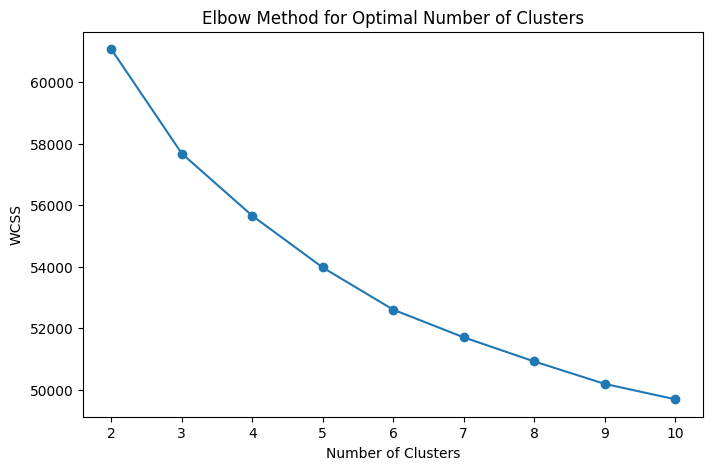

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### Silhouette Scores

Plot silhouette scores to evaluate cluster cohesion and separation.

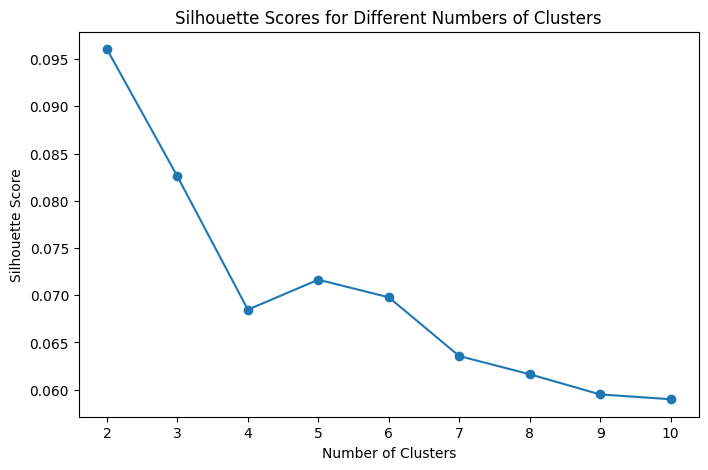

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Step 8: Train K-Means Clustering Model

Fit K-Means with the optimal number of clusters (e.g., 4 based on elbow/silhouette results).

In [10]:
optimal_clusters = 4  # Adjust based on elbow plot or silhouette score
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

## Step 9: Evaluate Cluster Characteristics

Analyze cluster means for numerical features and distributions for key categorical features.

In [11]:
cluster_summary = df.groupby('Cluster')[numerical_cols].mean()
print("Cluster Summary (Numerical Features):\n", cluster_summary)

Cluster Summary (Numerical Features):
                Age  Purchase Amount (USD)  Review Rating  Previous Purchases  \
Cluster                                                                        
0        43.411379              54.602845       3.757330           21.935449   
1        43.893473              53.552138       3.718830           21.809452   
2        45.157895              82.319737       3.842500           41.025000   
3        44.075028              55.124300       3.710078           20.796193   

                 CLV  Purchase_Frequency_Score  Discount_Sensitivity  \
Cluster                                                                
0        1116.018600                  4.012035              0.000000   
1        1068.137284                  3.979745              1.000000   
2        3340.831579                  3.918421              0.452632   
3        1049.070549                  3.888018              0.000000   

         Winter_Spring_Buyer  
Cluster         

In [12]:
for col in ['Gender', 'Category', 'Age_Group', 'Subscription Status']:
    print(f"\nCluster Distribution for {col}:\n", df.groupby('Cluster')[col].value_counts(normalize=True))


Cluster Distribution for Gender:
 Cluster  Gender
0        Female    0.561269
         Male      0.438731
1        Male      1.000000
2        Male      0.706579
         Female    0.293421
3        Female    0.573348
         Male      0.426652
Name: proportion, dtype: float64

Cluster Distribution for Category:
 Cluster  Category   
0        Clothing       0.446389
         Accessories    0.307440
         Footwear       0.166302
         Outerwear      0.079869
1        Clothing       0.432858
         Accessories    0.324081
         Footwear       0.152288
         Outerwear      0.090773
2        Clothing       0.452632
         Accessories    0.315789
         Footwear       0.159211
         Outerwear      0.072368
3        Clothing       0.456887
         Accessories    0.321389
         Footwear       0.137738
         Outerwear      0.083987
Name: proportion, dtype: float64

Cluster Distribution for Age_Group:
 Cluster  Age_Group
0        Middle       0.385120
         Seni

## Step 10: Visualize Clusters with PCA

Reduce dimensionality to 2D using PCA and plot clusters for visual inspection.

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['Cluster']

In [14]:
fig = px.scatter(df_pca, x='PCA1', y='PCA2', color='Cluster', 
                 title='Customer Segments Visualized with PCA',
                 labels={'PCA1': 'Principal Component 1', 'PCA2': 'Principal Component 2'})
fig.show()

## Step 11: Save Clustered Dataset

Export the dataset with cluster labels for further analysis or visualization.

In [15]:
df.to_csv('shopping_trends_clustered.csv', index=False)
print("Dataset with cluster labels saved to 'shopping_trends_clustered.csv'")

Dataset with cluster labels saved to 'shopping_trends_clustered.csv'


## Explanation of Clustering Steps

- **Preprocessing:** Scales numerical features and encodes categorical features for clustering.
- **Elbow/Silhouette:** Helps select the optimal number of clusters.
- **K-Means:** Segments customers into distinct groups.
- **Evaluation:** Summarizes cluster characteristics for business insights.
- **Visualization:** PCA scatter plot shows cluster separation.
- **Saving:** Cluster labels are added for downstream analysis.